# Evaluation scores



example: <br>
higher log probability ==> predicted class
if [score 0]=-2 and [score 1]=-3 then it means that the predicted class is class 0 <br>
[score] = -2+3 = 1 > 0 --> class 0
<br>
###########
<br>
if [score 0]=-3 and [score 1]=-2 then it means that the predicted class is class 1 <br>
[score] = -3+2 = -1 < 0 --> class 1

***
## Load the scores

In [39]:
import csv
import pandas as pd
from src.utils import *
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve, auc

In [27]:
# paths to csv score files
score_clean_csv = '../eval/scores_resnet_spec_eval.csv'
score_2dot0_csv = '../eval/scores_resnet_spec_eval_FGSM_2dot0.csv' 
score_3dot0_csv = '../eval/scores_resnet_spec_eval_FGSM_3dot0.csv'

scores_clean = pd.read_csv(score_clean_csv, delimiter=' ', header=None, engine='python')
scores_2dot0 = pd.read_csv(score_2dot0_csv, delimiter=' ', header=None, engine='python')
scores_3dot0 = pd.read_csv(score_3dot0_csv, delimiter=' ', header=None, engine='python')

In [28]:
# ground truth file of evaluation dataset (ASVSpoof2019)
config_path = '../config/residualnet_train_config.yaml'
config = read_yaml(config_path)
df_eval = pd.read_csv(os.path.join('..', config['df_eval_path']))

In [29]:
print(f'The length of the evaluation file list is {len(df_eval)}\n'
    f'The length of the clean score list is {len(scores_clean)}\n'
    f'The length of the epsilon=2.0 score list is {len(scores_2dot0)}\n'
    f'The length of the epsilon=3.0 score list is {len(scores_3dot0)}')

The length of the evaluation file list is 71237
The length of the clean score list is 71237
The length of the epsilon=2.0 score list is 71237
The length of the epsilon=3.0 score list is 71237


In [30]:
# the score values .csv uses a space as a delimiter between the file path and the score

def convert_column_to_binary(csv_file):
    binary_list = []
    
    with open(csv_file, 'r') as file:
        for line in file:
            # Split each line based on space 
            parts = line.strip().split()
            value = float(parts[1])
            
            try:
                if value > 0:
                    binary_list.append(0)
                else:
                    binary_list.append(1)
            except ValueError:
                pass
        
    return binary_list

In [31]:
pred_labels_clean = convert_column_to_binary(csv_file=score_clean_csv)
pred_labels_2dot0 = convert_column_to_binary(csv_file=score_2dot0_csv)
pred_labels_3dot0 = convert_column_to_binary(csv_file=score_3dot0_csv)

In [32]:
# get the GT labels
GT_labels = df_eval.iloc[:, -1].tolist()

***
## Unbalanced accuracy

In [38]:
unb_acc_clean = accuracy_score(y_true=GT_labels, y_pred=pred_labels_clean)
unb_acc_2dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_2dot0)
unb_acc_3dot0 = accuracy_score(y_true=GT_labels, y_pred=pred_labels_3dot0)

print(f'The unbalanced acc for clean eval set is {unb_acc_clean*100:.2f}%\n'
      f'The unbalanced acc for epsilon = 2.0 set is {unb_acc_2dot0*100:.2f}%\n'
      f'The unbalanced acc for epsilon = 3.0 set is {unb_acc_3dot0*100:.2f}%')


The unbalanced acc for clean eval set is 77.15%
The unbalanced acc for epsilon = 2.0 set is 36.29%
The unbalanced acc for epsilon = 3.0 set is 27.98%


***
## Balanced accuracy

In [37]:
bal_acc_clean = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_clean)
bal_acc_2dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_2dot0)
bal_acc_3dot0 = balanced_accuracy_score(y_true=GT_labels, y_pred=pred_labels_3dot0)

print(f'The balanced acc for clean eval set is {bal_acc_clean*100:.2f}%\n'
      f'The balanced acc for epsilon = 2.0 set is {bal_acc_2dot0*100:.2f}%\n'
      f'The balanced acc for epsilon = 3.0 set is {bal_acc_3dot0*100:.2f}%')

The balanced acc for clean eval set is 84.21%
The blanaced acc for epsilon = 2.0 set is 49.97%
The blanaced acc for epsilon = 3.0 set is 50.18%


***
## ROC curve and AUC

In [40]:
FP_clean, TP_clean, _ = roc_curve(GT_labels, pred_labels_clean)
ROC_AUC_clean = auc(FP_clean, TP_clean)

FP_2dot0, TP_2dot0, _ = roc_curve(GT_labels, pred_labels_2dot0)
ROC_AUC_2dot0 = auc(FP_2dot0, TP_2dot0)

FP_3dot0, TP_3dot0, _ = roc_curve(GT_labels, pred_labels_3dot0)
ROC_AUC_3dot0 = auc(FP_3dot0, TP_3dot0)

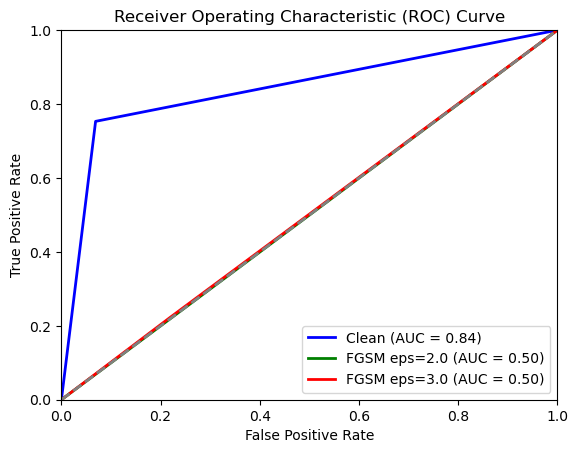

In [42]:
plt.figure()
plt.plot(FP_clean, TP_clean, color='blue', lw=2, label=f'Clean (AUC = {ROC_AUC_clean:.2f})')
plt.plot(FP_2dot0, TP_2dot0, color='green', lw=2, label=f'FGSM eps=2.0 (AUC = {ROC_AUC_2dot0:.2f})')
plt.plot(FP_3dot0, TP_3dot0, color='red', lw=2, label=f'FGSM eps=3.0 (AUC = {ROC_AUC_3dot0:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Computing the confusion matrix
* TN true negative, actual class was 0 (BF) and predicted as 0
* FP false positive, actual class was 0, but predicted as 1 (deep fake)
* FN false negative, actual class was 1, but predicted as 0
* TP true positive, actual class was 1 and predicted as 1

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# cm = confusion_matrix(true_labels, pred_labels)
# print(cm)
# 
# # [ TN    FP
# #   FN    TP ]

## Computing the indices of true positives
aka those audios with GT=1 and prediction=1, which means they are DF and the model correctly identified them as DF


In [ ]:
# def find_TP(list1, list2):
#     if len(list1) != len(list2):
#         raise ValueError
#     list = []
#     for i in range(len(list1)):
#         if (list1[i]==1 & list2[i]==1):
#             list.append(i)
#     return list    
# 
# TP_indices = find_TP(true_labels, pred_labels)
# TP_indices[:10]